In [214]:
import mne
import glob
import os
import scipy.io
from scipy.spatial.distance import cosine
import numpy as np
from pymatreader import read_mat
import matplotlib.pyplot as plt

#import rsatoolbox


In [215]:
################################ HELPER FUNCTIONS ################################ 

# create condlist
conditionlist = {
    'leading_Barn': 1,
    'leading_beach': 2,
    'leading_library': 3,
    'leading_restaurant': 4, 
    'leading_cave': 5,
    'trailing_church': 6,
    'trailing_conference_room': 7,
    'trailing_castle': 8, 
    'trailing_forest': 9      
}


# create category dict
#Idea: we create a customised event_id dict that allows us to later just extract the trailing images corresponding to our transitional probabiliy categories

# Mapping VALID CONDITIONS (75%): 
    # leading_barn -> trailing_church
    # leading_beach -> trailing_church
    # leading_library -> trailing_conference_room
    # leading_restaurant ->  trailing_conference_room

# Mapping INVALID CONDITIONS (25%): 
    # leading_barn -> trailing_conference_room
    # leading_beach -> trailing_conference_room
    # leading_library -> trailing_church
    # leading_restaurant -> trailing_church
    
# Mapping CONTROL CONDITIONS (50%): 
    # leading_cave -> trailing_castle
    # leading_cave -> trailing_forest
    
category_dict = {
    0: (1, 6), # valid conditions 75 %
    1: (2, 6), # leading_beach -> trailing_church
    2: (3, 7), # leading_library -> trailing_conference_room
    3: (4, 7),  # leading_restaurant ->  trailing_conference_room
    4: (1, 7), # invalid conditions 0.25 %
    5: (2, 7),
    6: (3, 6), 
    7: (4, 6), 
    8: (5, 8), # control conditions 50 %
    9: (5, 9)
}






def convert_trialinfo(data, mapping):
    '''This function converts condition label strings into integer based on the mapping in conditionlist.
        Input: data, condition mapping
        Returns: List of integers
    '''    
    if "trialinfo" in data:
        trialinfo_labels = data["trialinfo"]
    else:
        raise KeyError("'trialinfo' field is missing in data['fD']")

    return np.array([mapping[cond] for cond in trialinfo_labels])


def map_events(event_id, category_dict):
    """
    This function creates a customised event_id dict that allows us to later just extract the trailing images 
    corresponding to our transitional probabiliy categories
    Maps events based on specified (leading, trailing) pairs in category_dict.
    
    Parameters:
    - event_id (list or array-like): List of event IDs.
    - category_dict (dict): Dictionary mapping keys to (leading, trailing) event pairs.
    
    Returns:
    - list: Mapped event categories based on leading-trailing pairs.
    """
    # Initialize event_maps with -1 for each event
    event_maps = [-1] * len(event_id)
    
    # Iterate over event IDs, starting from the second event
    for idx in range(1, len(event_id)):
        # Check if the current and previous event form a valid (leading, trailing) pair
        for key, (leading, trailing) in category_dict.items():
            if idx > 0 and (event_id[idx - 1] == leading) and (event_id[idx] == trailing):
                event_maps[idx] = key
    
    return event_maps




def get_unique_event_ids(event_id):
    """
    Retrieves unique event IDs, excluding the specified unwanted value (-1).
    
    Parameters:
    - event_id (list or array-like): List of event IDs.
    
    Returns:
    - numpy array: Array of unique event IDs, excluding -1.
    """
    # Get unique event IDs and filter out -1
    unique_event_ids = np.unique(event_id)
    unique_event_ids = unique_event_ids[unique_event_ids != -1]
    
    return unique_event_ids



# Define resultspath
results_path_eeg = "/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/eeg_RDM"





[7 4 7 ... 6 1 7]
Not setting metadata
3455 matching events found
No baseline correction applied
0 projection items activated


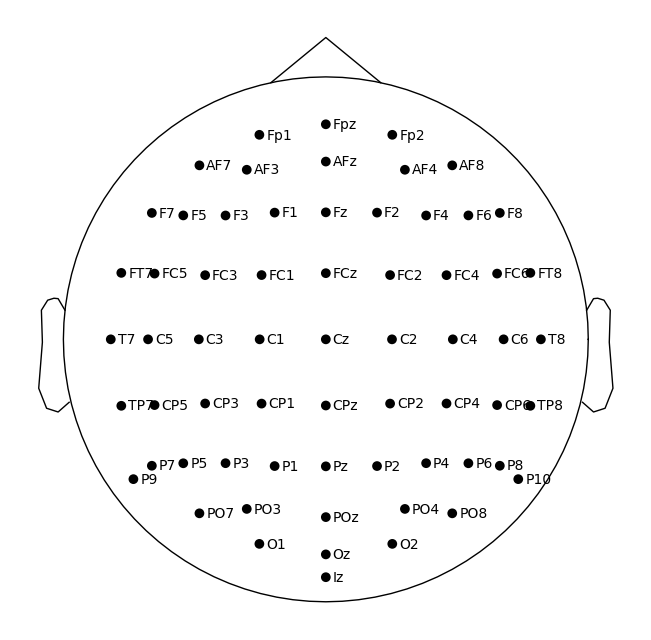

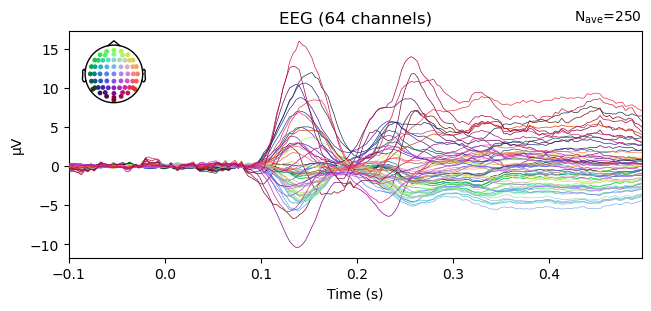

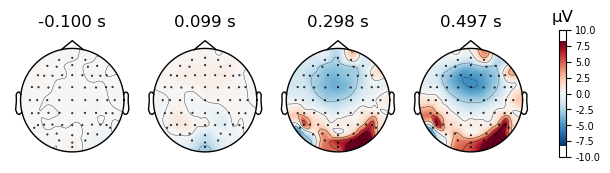

In [126]:
################################ LOAD DATA ################################ 

# Load the FieldTrip .mat file
fname = "/Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/eTadff_sub17.mat"
#fname "/Users/denisekittelmann/Documents/MATLAB/Hannah_data/EEG/P02/fD/eTadff_sub02.mat"
data = read_mat(fname)["fD"]

# Convert string labels into integer labels 
data["trialinfo"] = convert_trialinfo(data, conditionlist)
print(data["trialinfo"])

# read the fields that we will need later
epochs_data = np.array(data["trial"]) * 1e-6 # the mat file says the unit is V, but I think it's actually muV
tmin = data['time'][0][0]
sfreq = int(1. / (data['time'][0][1] - tmin))
ch_names = data["label"]
ch_types = data["elec"]["chantype"]
montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)  # we could read the ch locations from file, but here we just read the cap used in the experiment
# event_dict = {}

event_id = list(data["trialinfo"])
events = np.stack([np.arange(len(event_id)),
                   np.zeros_like(event_id), 
                   event_id], axis=1)
# event_dict <- this will be a useful parameter to set, but we'll need to know what numbers stand for what condition


# create the info field
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create an MNE Epochs object
epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                         events=events, event_id=event_id) 

# set the montage for correct channel positions
epochs = epochs.set_montage(montage)

# plot different events to check if everything sits right
epochs.plot_sensors(show_names=True);
epochs["1"].average().plot();
epochs["2"].average().plot_topomap();

In [216]:
################################ CREATE CUSTOMISED EVENT ID DICT ################################ 

#Idea: we create a customised event_id dict that allows us to later just extract the trailing images corresponding to our transitional probabiliy categories

# Mapping VALID CONDITIONS (75%): 
    # leading_barn -> trailing_church
    # leading_beach -> trailing_church
    # leading_library -> trailing_conference_room
    # leading_restaurant ->  trailing_conference_room

# Mapping INVALID CONDITIONS (25%): 
    # leading_barn -> trailing_conference_room
    # leading_beach -> trailing_conference_room
    # leading_library -> trailing_church
    # leading_restaurant -> trailing_church
    
# Mapping CONTROL CONDITIONS (50%): 
    # leading_cave -> trailing_castle
    # leading_cave -> trailing_forest
    
category_dict = {
    0: (1, 6), # valid conditions 75 %
    1: (2, 6), # leading_beach -> trailing_church
    2: (3, 7), # leading_library -> trailing_conference_room
    3: (4, 7),  # leading_restaurant ->  trailing_conference_room
    4: (1, 7), # invalid conditions 0.25 %
    5: (2, 7),
    6: (3, 6), 
    7: (4, 6), 
    8: (5, 8), # control conditions 50 %
    9: (5, 9)
}


rdm_dict = {
    0: (0,1), # 0.75%
    1: (2,3), # 0. 75 % 
    2: (4,5), # 0.25 % 
    3: (6,7), # 0.25 %
    4: (8,), # 0.5 % 
    5: (9,)  # 0.5 %  
}


event_maps = [-1] * len(event_id)
for idx in range(1, len(event_id)):
    #print("idx:", idx)
    # Check if the current and previous event form a valid (leading, trailing) pair
    for key, (leading, trailing) in category_dict.items():
        if idx > 0 and (event_id[idx - 1] == leading) and (event_id[idx] == trailing):
            event_maps[idx] = key
                       
#event_id = event_maps



Reduced RDM_EARLY:
 [[0.         0.34936549 0.42265316 0.40880657 0.92184914 0.48834164]
 [0.34936549 0.         0.39256035 0.23423209 1.00718667 0.37716093]
 [0.42265316 0.39256035 0.         0.27874288 0.94445641 0.46261594]
 [0.40880657 0.23423209 0.27874288 0.         0.81695654 0.44631117]
 [0.92184914 1.00718667 0.94445641 0.81695654 0.         1.28460329]
 [0.48834164 0.37716093 0.46261594 0.44631117 1.28460329 0.        ]]


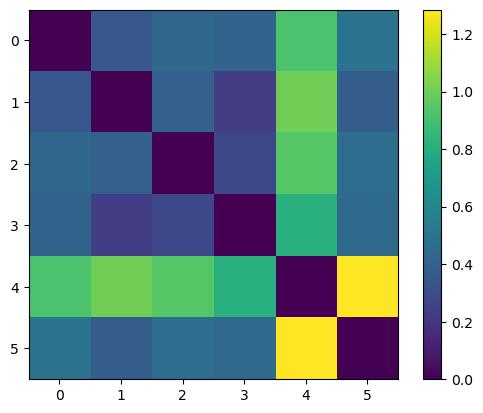

In [132]:

# Step 1: Compute mean representation for each new category defined in rdm_dict for rdm_early
mean_representations_early = {}

early_start, early_end = 0.128, 0.180
epochs_early = epochs.copy().crop(tmin=early_start, tmax=early_end)


for new_category, original_indices in rdm_dict.items():
    # Gather all epochs for the current new category
    if isinstance(original_indices, int):
        original_indices = [original_indices]
    
    epochs_group = [epochs_early[event_name] for event_name in original_indices]
    # Calculate the mean representation for this group
    mean_representation = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_group], axis=0)
    mean_representations_early[new_category] = mean_representation

# Step 2: Initialize a 6x6 RDM and compute pairwise cosine similarity between mean representations
n_categories = len(rdm_dict)
rdm_reduced = np.zeros((n_categories, n_categories))

for i in range(n_categories):
    for j in range(n_categories):
        arr_i = mean_representations_early[i]
        arr_j = mean_representations_early[j]
        rdm_reduced[i, j] = cosine(arr_i, arr_j)

# Output the reduced RDM for early time window
print("Reduced RDM_EARLY:\n", rdm_reduced)

plt.imshow(rdm_reduced, cmap='viridis') # twilight_shifted inferno plasma 
plt.colorbar()
plt.show()

Reduced RDM_EARLY:
 [[0.         0.58871163 0.33382727 0.28284444 0.46129505 0.1653915 ]
 [0.58871163 0.         0.74244879 0.7284008  0.54077866 0.78078459]
 [0.33382727 0.74244879 0.         0.58195261 0.4615797  0.44114825]
 [0.28284444 0.7284008  0.58195261 0.         0.67864988 0.31169477]
 [0.46129505 0.54077866 0.4615797  0.67864988 0.         0.6687788 ]
 [0.1653915  0.78078459 0.44114825 0.31169477 0.6687788  0.        ]]


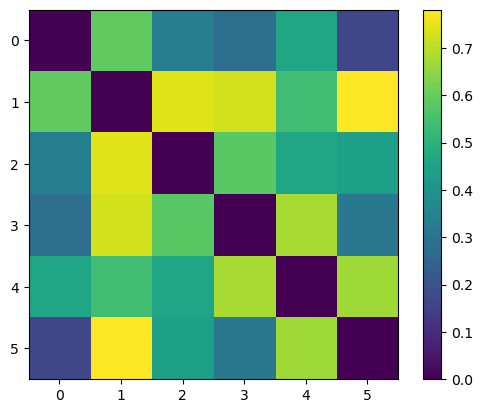

In [187]:

# Initialize the reduced RDM matrix
early_start, early_end = 0.128, 0.180
late_start, late_end = 0.280, 0.296

epochs_early = epochs.copy().crop(tmin=early_start, tmax=early_end)
epochs_late = epochs.copy().crop(tmin=late_start, tmax=late_end)

    # Define time windows for H1 & H3
b1 = epochs[:len(epochs) // 2]
b2 = epochs[len(epochs) // 2:]



n_categories = len(rdm_dict)
rdm_reduced = np.zeros((n_categories, n_categories))

# Compute mean representations and RDM values in one loop
for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
    for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
        
        if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
            idx_i = [idx_i]
            
        if isinstance(idx_j, int):
            idx_j = [idx_j]
        
        epochs_i = [epochs_early[event_name] for event_name in idx_i]
        mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
        
        epochs_j = [epochs_early[event_name] for event_name in idx_j]
        mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
        
        rdm_reduced[i, j] = cosine(mean_representation_i, mean_representation_j)
            

# Output the reduced RDM for early time window
print("Reduced RDM_EARLY:\n", rdm_reduced)

plt.imshow(rdm_reduced, cmap='viridis') # twilight_shifted inferno plasma 
plt.colorbar()
plt.show()

In [107]:
def read_custom_epochs(data):
    # Read .mat file and extract required data
    #data = read_mat(fname)["fD"] 
    data = data
    # Extract and process relevant fields
    epochs_data = np.array(data["trial"]) * 1e-6  # Assuming data is in muV
    tmin = data['time'][0][0]
    sfreq = int(1. / (data['time'][0][1] - tmin))
    ch_names = data["label"]
    ch_types = data["elec"]["chantype"]
    montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)
    
    # Extract event information
    event_id = list(data["trialinfo"]) # categories 1-9 
    events = np.stack([np.arange(len(event_id)),
                       np.zeros_like(event_id), 
                       event_id], axis=1)

    # Create the MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create the MNE Epochs object
    epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                             events=events, event_id=event_id)

    # Set the montage for channel positions
    epochs = epochs.set_montage(montage)

    # Plot to verify
    #epochs.plot_sensors(show_names=True)
    #epochs["5"].average().plot()
    #epochs["leading_restaurant"].average().plot_topomap()

    return epochs

In [111]:
def read_custom_epochs(data, event_id, event_codes):
    """
    Reads and processes EEG epochs from a structured data dictionary.
    
    Parameters:
    - data (dict): Dictionary containing trial data, time, labels, and trial info.
    - event_id (dict): Mapping of event names to integer codes.
    - event_codes (array): Array of event codes matching the epochs.
    
    Returns:
    - mne.EpochsArray: MNE epochs object with the specified event structure.
    """
    # Process the epochs data (converting units if in microvolts)
    epochs_data = np.array(data["trial"]) * 1e-6  # Assuming data is in µV
    tmin = data['time'][0][0]
    sfreq = int(1. / (data['time'][0][1] - tmin))
    ch_names = data["label"]
    ch_types = ["eeg"] * len(ch_names)  # Assuming all channels are EEG, update if needed

    # Define montage for electrode positions
    montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)

    # Create the `events` array with format (index, 0, event_code)
    events = np.column_stack((np.arange(len(event_codes)), np.zeros(len(event_codes), int), event_codes))

    # Create the MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create the MNE Epochs object
    epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin, events=events, event_id=event_id)

    # Set the montage for channel positions
    epochs.set_montage(montage)

    return epochs

In [ ]:
################################ COMPUTE EEG RDM ################################ 

# Define dir where EEG can be found 
dir = "/Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/"

# Create iterator
ids = [pid for pid in range(1, 32) if pid != 20] 

# Loop over all participants and compute EEG RDMs for each hypothesis
for pid in ids:
    
    print(pid)

    fname = os.path.join(dir, f"eTadff_sub{pid:02d}.mat")
    data = read_mat(fname)["fD"]

    data["trialinfo"] = convert_trialinfo(data, conditionlist)
    print(data["trialinfo"])
    

    # read the fields that we will need later
    epochs_data = np.array(data["trial"]) * 1e-6 # muV
    tmin = data['time'][0][0]
    sfreq = int(1. / (data['time'][0][1] - tmin))
    ch_names = data["label"]
    ch_types = data["elec"]["chantype"]
    montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)  
    # event_dict = {}

    event_id = list(data["trialinfo"])
    events = np.stack([np.arange(len(event_id)),
                    np.zeros_like(event_id), 
                    event_id], axis=1)
    
    # create the info field
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create an MNE Epochs object
    epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                            events=events, event_id=event_id) 

    # set the montage for correct channel positions
    epochs = epochs.set_montage(montage)

    
    event_id = map_events(event_id, category_dict)
    print("event_id:",event_id)


    ################################ COMPUTE EEG RDM ################################ 
    print(f"################################ Preparing to compute RDMs for participant {pid:02d} ################################")
    
    unique_event_ids = get_unique_event_ids(event_id) # returns all event ids except -1 as these are the leading trials not needed here
    n_events = len(unique_event_ids)

    # Construct empty RDMs
    rdm_b1 = np.zeros((n_events, n_events))
    rdm_b2 = np.zeros((n_events, n_events))
    rdm_early = np.zeros((n_events, n_events))
    rdm_late = np.zeros((n_events, n_events))

    # List of event ids to loop through 
    event_names = unique_event_ids   
    #print("event_name:",event_names)

    # Define time windows for H1
    early_start, early_end = 0.128, 0.180
    late_start, late_end = 0.280, 0.296

    epochs_early = epochs.copy().crop(tmin=early_start, tmax=early_end)
    epochs_late = epochs.copy().crop(tmin=late_start, tmax=late_end)

    # Define time windows for H1 & H3
    b1 = epochs[:len(epochs) // 2]
    b2 = epochs[len(epochs) // 2:]


    # Compute EEG RDMs for each participant
    print(f"################################ Starting to compute RDMs for participant {pid:02d} ################################")
    
    for i, event_name_i in enumerate(event_names):
        for j, event_name_j in enumerate(event_names):
            
            epochs_early_i = epochs_early[event_name_i]
            epochs_early_j = epochs_early[event_name_j]

            arr_1 = epochs_early_i.average().get_data().reshape(-1)
            arr_2 = epochs_early_j.average().get_data().reshape(-1)
            rdm_early[i, j] = cosine(arr_1, arr_2)

    print(f"################################ Finished computing RDM_EARLY for participant {pid:02d}. STARTING DO COMPUTE RDM_LATE. ################################")
    
    for i, event_name_i in enumerate(event_names):
        for j, event_name_j in enumerate(event_names):
            
            epochs_late_i = epochs_late[event_name_i]
            epochs_late_j = epochs_late[event_name_j]

            arr_1 = epochs_late_i.average().get_data().reshape(-1)
            arr_2 = epochs_late_j.average().get_data().reshape(-1)
            rdm_late[i, j] = cosine(arr_1, arr_2)
 
    print(f"################################ Finished computing RDM_LATE for participant {pid:02d}. STARTING DO COMPUTE RDM_B1. ################################")

    # Iterate over event names
    for i, event_name_i in enumerate(event_names):
        for j, event_name_j in enumerate(event_names):
            
            epochs_half_i = b1[event_name_i]
            epochs_half_j = b1[event_name_j]

            arr_1 = epochs_half_i.average().get_data().reshape(-1)
            arr_2 = epochs_half_j.average().get_data().reshape(-1)
            rdm_b1[i, j] = cosine(arr_1, arr_2)

    print(f"################################ Finished computing RDM_B1 for participant {pid:02d}. STARTING DO COMPUTE RDM_B2. ################################")
    
    for i, event_name_i in enumerate(event_names):
        for j, event_name_j in enumerate(event_names):
            
            epochs_half_i = b2[event_name_i]
            epochs_half_j = b2[event_name_j]
            
            arr_1 = epochs_half_i.average().get_data().reshape(-1)
            arr_2 = epochs_half_j.average().get_data().reshape(-1)
            rdm_b2[i, j] = cosine(arr_1, arr_2)
            
    print(f"################################ Finished computing RDM_B2 for participant {pid:02d} ################################")

    print(f"################################ Saving RDMs for participant {pid:02d} ################################")
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_early_sub{pid:02d}.npy"), rdm_early)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_late_sub{pid:02d}.npy"), rdm_late)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_b1_sub{pid:02d}.npy"), rdm_b1)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy"), rdm_b2)



# convert correction to z test on sample t-test 
# pearson correlation correlations to z score  ->  at the group level; fishers rank correlation parametric way more producible 
# standard fehler sample size  -> alle einträge in der der matrix -> 9 X 9 
# 
# scipy rank correlation  before flatten
    
        

1
[3 7 4 ... 6 1 7]
Not setting metadata
3456 matching events found
No baseline correction applied
0 projection items activated
event_id: [-1, 2, -1, 3, -1, 0, -1, 1, -1, 9, -1, 9, -1, 9, -1, 8, -1, 1, -1, 4, -1, 1, -1, 2, -1, 1, -1, 9, -1, 1, -1, 2, -1, 2, -1, 2, -1, 3, -1, 3, -1, 1, -1, 8, -1, 8, -1, 9, -1, 7, -1, 2, -1, 7, -1, 3, -1, 8, -1, 9, -1, 0, -1, 9, -1, 3, -1, 8, -1, 9, -1, 8, -1, 1, -1, 7, -1, 8, -1, 9, -1, 8, -1, 3, -1, 8, -1, 8, -1, 9, -1, 1, -1, 1, -1, 1, -1, 0, -1, 0, -1, 3, -1, 5, -1, 2, -1, 8, -1, 8, -1, 8, -1, 8, -1, 8, -1, 1, -1, 2, -1, 1, -1, 8, -1, 1, -1, 0, -1, 4, -1, 1, -1, 3, -1, 1, -1, 9, -1, 3, -1, 1, -1, 6, -1, 2, -1, 8, -1, 1, -1, 8, -1, 5, -1, 1, -1, 8, -1, 2, -1, 9, -1, 8, -1, 9, -1, 6, -1, 1, -1, 6, -1, 9, -1, 3, -1, 5, -1, 0, -1, 3, -1, 6, -1, 3, -1, 1, -1, 9, -1, 6, -1, 8, -1, 8, -1, 9, -1, 8, -1, 1, -1, 0, -1, 9, -1, 4, -1, 2, -1, 0, -1, 6, -1, 1, -1, 6, -1, 8, -1, 8, -1, 1, -1, 2, -1, 1, -1, 7, -1, 1, -1, 2, -1, 1, -1, 3, -1, 0, -1, 3, -1, 9, -1, 8, 

In [217]:
################################ COMPUTE EEG RDM ################################ 

# Define dir where EEG can be found 
dir = "/Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/"

# Create iterator
ids = [pid for pid in range(1, 32) if pid != 20] 

# Loop over all participants and compute EEG RDMs for each hypothesis
for pid in ids:
    
    print(pid)

    fname = os.path.join(dir, f"eTadff_sub{pid:02d}.mat")
    data = read_mat(fname)["fD"]

    data["trialinfo"] = convert_trialinfo(data, conditionlist)
    print(data["trialinfo"])
    

    # read the fields that we will need later
    epochs_data = np.array(data["trial"]) * 1e-6 # muV
    tmin = data['time'][0][0]
    sfreq = int(1. / (data['time'][0][1] - tmin))
    ch_names = data["label"]
    ch_types = data["elec"]["chantype"]
    montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)  
    # event_dict = {}

    event_id = list(data["trialinfo"])
    events = np.stack([np.arange(len(event_id)),
                    np.zeros_like(event_id), 
                    event_id], axis=1)
    
    # create the info field
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create an MNE Epochs object
    epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                            events=events, event_id=event_id) 

    # set the montage for correct channel positions
    epochs = epochs.set_montage(montage)

    
    event_id = map_events(event_id, category_dict)
    print("event_id:",event_id)


    ################################ COMPUTE EEG RDM ################################ 
    print(f"################################ Preparing to compute RDMs for participant {pid:02d} ################################")
    
    # Construct empty RDMs
    n_categories = len(rdm_dict)
    rdm_b1 = np.zeros((n_categories, n_categories))
    rdm_b2 = np.zeros((n_categories, n_categories))
    rdm_early = np.zeros((n_categories, n_categories))
    rdm_late = np.zeros((n_categories, n_categories))
    
    # Define time windows for H2
    early_start, early_end = 0.128, 0.180
    late_start, late_end = 0.280, 0.296

    epochs_early = epochs.copy().crop(tmin=early_start, tmax=early_end)
    epochs_late = epochs.copy().crop(tmin=late_start, tmax=late_end)


    # Compute EEG RDMs for each participant
    print(f"################################ Starting to compute RDMs for participant {pid:02d} ################################")
    
    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [b1[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [b1[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_b1[i, j] = cosine(mean_representation_i, mean_representation_j)

    print(f"################################ Finished computing RDM_B1 for participant {pid:02d}. STARTING DO COMPUTE RDM_B2. ################################")
    
    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [b2[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [b2[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_b2[i, j] = cosine(mean_representation_i, mean_representation_j)
 
    print(f"################################ Finished computing RDM_B2 for participant {pid:02d}. STARTING DO COMPUTE RDM_EARLY. ################################")

    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [epochs_early[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [epochs_early[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_early[i, j] = cosine(mean_representation_i, mean_representation_j)

    print(f"################################ Finished computing RDM_EARLY for participant {pid:02d}. STARTING DO COMPUTE RDM_LATE. ################################")
    
    for i, (category_i, idx_i) in enumerate(rdm_dict.items()):
        for j, (category_j, idx_j) in enumerate(rdm_dict.items()):
            
            if isinstance(idx_i, int): # to account for cat 4 & 5 which are just single integers
                idx_i = [idx_i]
                
            if isinstance(idx_j, int):
                idx_j = [idx_j]
            
            epochs_i = [epochs_late[event_name] for event_name in idx_i]
            mean_representation_i = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_i], axis=0)
            
            epochs_j = [epochs_late[event_name] for event_name in idx_j]
            mean_representation_j = np.mean([epoch.average().get_data().reshape(-1) for epoch in epochs_j], axis=0)
            
            rdm_late[i, j] = cosine(mean_representation_i, mean_representation_j)
            
    print(f"################################ Finished computing RDM_B2 for participant {pid:02d} ################################")

    print(f"################################ Saving RDMs for participant {pid:02d} ################################")
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_b1_sub{pid:02d}.npy"), rdm_b1)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_b2_sub{pid:02d}.npy"), rdm_b2)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_early_sub{pid:02d}.npy"), rdm_early)
    np.save(os.path.join(results_path_eeg, f"eeg_rdm_late_sub{pid:02d}.npy"), rdm_late)


# convert correction to z test on sample t-test 
# pearson correlation correlations to z score  ->  at the group level; fishers rank correlation parametric way more producible 
# standard fehler sample size  -> alle einträge in der der matrix -> 9 X 9 
# 
# scipy rank correlation  before flatten
    
        

1
[3 7 4 ... 6 1 7]
Not setting metadata
3456 matching events found
No baseline correction applied
0 projection items activated
event_id: [-1, 2, -1, 3, -1, 0, -1, 1, -1, 9, -1, 9, -1, 9, -1, 8, -1, 1, -1, 4, -1, 1, -1, 2, -1, 1, -1, 9, -1, 1, -1, 2, -1, 2, -1, 2, -1, 3, -1, 3, -1, 1, -1, 8, -1, 8, -1, 9, -1, 7, -1, 2, -1, 7, -1, 3, -1, 8, -1, 9, -1, 0, -1, 9, -1, 3, -1, 8, -1, 9, -1, 8, -1, 1, -1, 7, -1, 8, -1, 9, -1, 8, -1, 3, -1, 8, -1, 8, -1, 9, -1, 1, -1, 1, -1, 1, -1, 0, -1, 0, -1, 3, -1, 5, -1, 2, -1, 8, -1, 8, -1, 8, -1, 8, -1, 8, -1, 1, -1, 2, -1, 1, -1, 8, -1, 1, -1, 0, -1, 4, -1, 1, -1, 3, -1, 1, -1, 9, -1, 3, -1, 1, -1, 6, -1, 2, -1, 8, -1, 1, -1, 8, -1, 5, -1, 1, -1, 8, -1, 2, -1, 9, -1, 8, -1, 9, -1, 6, -1, 1, -1, 6, -1, 9, -1, 3, -1, 5, -1, 0, -1, 3, -1, 6, -1, 3, -1, 1, -1, 9, -1, 6, -1, 8, -1, 8, -1, 9, -1, 8, -1, 1, -1, 0, -1, 9, -1, 4, -1, 2, -1, 0, -1, 6, -1, 1, -1, 6, -1, 8, -1, 8, -1, 1, -1, 2, -1, 1, -1, 7, -1, 1, -1, 2, -1, 1, -1, 3, -1, 0, -1, 3, -1, 9, -1, 8, 

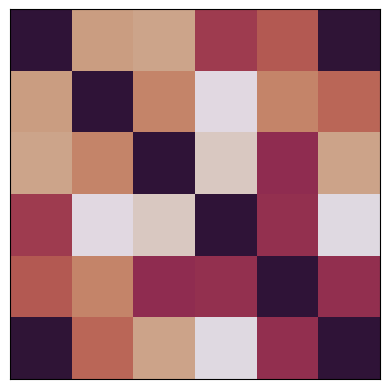

In [ ]:
################################ PLOT EEG RDMs ################################ 

# just a quick visual check whether everything worked out correctly

rdm = np.load('/Users/denisekittelmann/Documents/Python/BiMoL/results/rdms/eeg_RDM/eeg_rdm_b2_sub01.npy')
plt.imshow(rdm, cmap='twilight_shifted') # twilight_shifted inferno plasma 
#plt.xticks([])
#plt.yticks([])
plt.show()
plt.close()

In [ ]:
################################ COMPUTE ANN RDMs ################################ 

dir_pcn = "/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/final_model_pcn_lr1e-7_trained.keras"
dir_bpann = "/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/final_model_bp_lr1e-7_trained.keras"

# ToDo add best model -> check 
# look at validation performance -> min (max (from validation accuracy history_pcn), max (from validation accuracy history_bp)) -> checl 
# zeitvisucheckend -schick dirk visually alllich -> check 

# Load the model
pcn = tf.keras.models.load_model(dir_pcn) 
bp_ann = tf.keras.models.load_model(dir_bpann)


# list all layer names
for layer in pcn.layers:
    print(layer.name)
    
for layer in bp_ann.layers:
    print(layer.name)    
    
# Extract Layer 1’s output
layer1_output = pcn.get_layer('layer_name_1').output # output layer 1
layer1_output = bp_ann.get_layer('layer_name_1').output# adapt 

layer1_model_pcn = Model(inputs=pcn.input, outputs=layer1_output) 
    



# Create dict to map labels stimulus categories

cat_dict = {1: (0, 1),
            2: (0, 2)
            }

def batch_drawing_function(valid_cat):
  # add the drwaing according to the mapping
  # 35 leading
  # 45 trailing 
  

rdm_h1_pcn = np.zeros([9, 9])
rdm_h1_bp = np.zeros([9, 9])

rdm_h23_pcn_l1 = np.zeros([9, 9])
rdm_h23_pcn_l2 = np.zeros([9, 9])
rdm_h23_bp_l1 = np.zeros([9, 9])
rdm_h23_bp_l2 = np.zeros([9, 9])

#rdm_h2 = np.zeros([9, 9])
#rdm_h3 =np.zeros([9, 9])

for category_l in cat_dict:
  for category_t in cat_dict: 

    batch_i = batch_drawing_function(category_l)
    pcn_acts_i = pcn(batch_i)

    batch_j = batch_drawing_function(category_t)
    pcn_acts_j = pcn(batch_j)
    
    batch_i = batch_drawing_function(category_l)
    bp_acts_i = bp_ann(batch_i)

    batch_j = batch_drawing_function(category_t)
    bp_acts_j = bp_ann(batch_j)
    
    
        # H1
    rdm_h1_pcn[i, j] = cosine(np.mean(pcn_acts_i[0], axis=0), np.mean(pcn_acts_j[0], axis=0))
    rdm_h1_bp[i, j] = cosine(np.mean(bp_acts_i[1], axis=0), np.mean(bp_acts_j[1], axis=0))
    
      # H2 &H3
    rdm_h23_pcn_l1[i, j] = cosine(np.mean(np.concatenate([layer for layer in pcn_acts_i], axis=1), axis=0), np.mean(np.concatenate([layer for layer in pcn_acts_j], axis=1), axis=0))
    rdm_h23_bp_l1[i, j] = cosine(np.mean(np.concatenate([layer for layer in bp_acts_i], axis=1), axis=0), np.mean(np.concatenate([layer for layer in bp_acts_j], axis=1), axis=0)) 
    rdm_h23_pcn_l2[i, j] = cosine(np.mean(np.concatenate([layer for layer in pcn_acts_i], axis=1), axis=0), np.mean(np.concatenate([layer for layer in pcn_acts_j], axis=1), axis=0))
    rdm_h23_bp_l2[i, j] = cosine(np.mean(np.concatenate([layer for layer in bp_acts_i], axis=1), axis=0), np.mean(np.concatenate([layer for layer in bp_acts_j], axis=1), axis=0)) 
    
plt.imshow(rdm)
plt.colorbar()



In [ ]:
################################ COMPUTE SIMILARITY BETWEEN RDMs ################################ 

# Spearman’s correlation 









In [ ]:
################################ STATISTICALLY TEST SIMILARITIES ################################ 

# non parametric test: permutation test? -> nur replicable with z scoring 





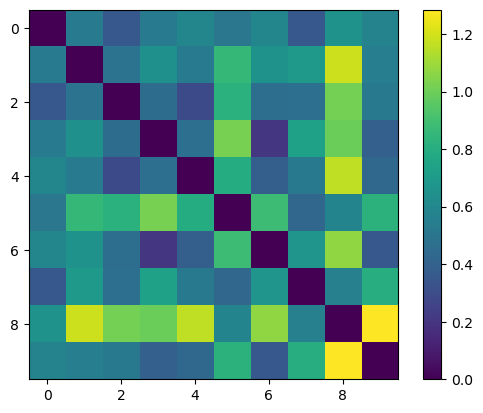

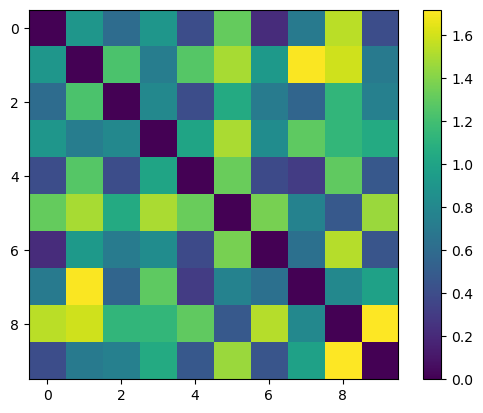

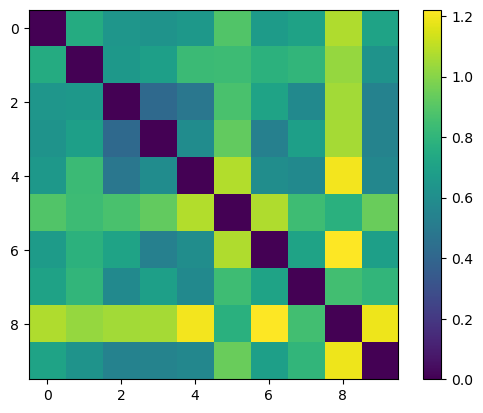

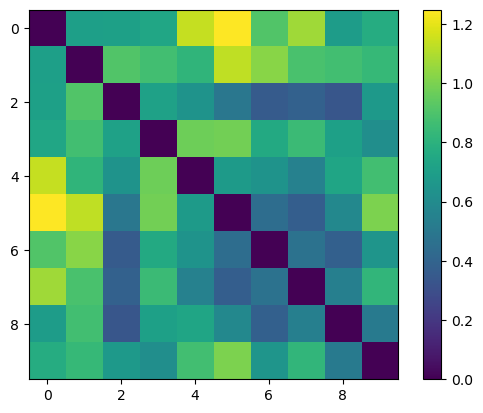

In [69]:
plt.imshow(rdm_early, cmap='viridis') # twilight_shifted inferno plasma 
plt.colorbar()
plt.show()
plt.close()

plt.imshow(rdm_late, cmap='viridis') # twilight_shifted inferno plasma 
plt.colorbar()
plt.show()
#np.save("eeg_rdm.npy", rdm)
plt.close()

plt.imshow(rdm_b1, cmap='viridis') # twilight_shifted inferno plasma 
plt.colorbar()
plt.show()
plt.close()

plt.imshow(rdm_b2, cmap='viridis') # twilight_shifted inferno plasma 
plt.colorbar()
plt.show()
#np.save("eeg_rdm.npy", rdm)
plt.close()